<a href="https://colab.research.google.com/github/arnab-mkj/Data-driven-operator-learning/blob/main/deep_operator_learning_deeponet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.integrate import trapezoid # For numerical integration
import matplotlib.pyplot as plt
from typing import Tuple, Callable, Sequence
import numpy as np

import flax.linen as nn
from flax.training import train_state
import optax

In [2]:
key = jax.random.key(0)

###  Defining the Gaussian Random Field (GRF) for u(x)
We'll generate our input functions u(x) from a GRF. This requires defining a kernel function (we'll use RBF) and a way to sample from the GRF.

The Radial Basis Function (RBF) kernel, or squared exponential kernel, is defined as:
$$
k(x_1, x_2) =  \exp\left(-\frac{\|x_1 - x_2\|^2}{2l^2}\right)
$$

$l$ is the length-scale.

In [3]:
def rbf_kernel(x1: jnp.ndarray, x2: jnp.ndarray, length_scale: float) -> jnp.ndarray:
  """
  Computes the RBF kernel between two sets of points.
  x1, x2: (N,D) array of N points in D dimension
  length_scale: the length scale of the kernel
  Returns: (N, M) kernel matrix
  """
  x1 = jnp.atleast_2d(x1)
  x2 = jnp.atleast_2d(x2)

  # COmpute the squared Eucledian distance
  diff = x1[:, None, :] - x2[None, :, :] #(N,M,D)
  sq_dist = jnp.sum(diff**2, axis=-1) #(N,M)
  exp_value = jnp.exp(-0.5 * sq_dist / length_scale**2)
  # print("exp_rbf_kernel: ", exp_value)
  return exp_value

def gram_matrix(kernel_fn: Callable, x: jnp.ndarray) -> jnp.ndarray:
  """Computes the gram matrix(x,x) for a given kernel and points x"""
  return kernel_fn(x, x)


### Sampling from GRF

To sample a function u(x) from G(0, k(x,x')) at points x_eval_pts, we sample from a multivariate Normal distribution: u ~ N(0, K), where K is the Gram matrix k(x_eval_pts, x_eval_pts).

In [4]:

def sample_grf(key: jax.random.key, kernel_fn: Callable, eval_pts: jnp.ndarray, num_samples: int, jitter: float = 1e-3) -> jnp.ndarray:
  """
  Samples the function from a GRF
  kernel_fn: Callable that takes (x1, x2) and returns a kernel matrix
  eval_pts: (N-eval, D) array of points at which to evaluate the GRF
  jitter: small value to add to diagonal for numerical stability
  Returns: (num_samples, N_eval) array of function samples
  """
  K = gram_matrix(kernel_fn, eval_pts) # eval_points is x_fine_grid
  K_stable = K + jitter * jnp.eye(K.shape[0])  # for numerical stability since for cholesky decomp, the matric must be positivr definite

  # print("K: ", K, K.shape)
  # print("K_stable: ", K_stable)
  # Cholesky decomposition: L L^T = K
  L = jnp.linalg.cholesky(K_stable)
  # print("L: ", L)

  #Standard normal smaples
  z = jax.random.normal(key, shape = (K.shape[1], num_samples)) # Shape(N_eval, num_samples)
  # print("z:", z)

  # u = L @ z
  samples = jnp.dot(L, z).T # Shape (num-samples, N_eval)
  #This matrix multiplication takes each column of independent random numbers in z and transforms it into a column of correlated random numbers.
  # The output is a set of values for one of our smooth functions.
  # print(samples) # nan
  return samples


In [5]:
# domain for u(x) and y
domain_start = 0.0
domain_end = 1.0

# Fine grid for defining u(x)
num_fine_pts = 200
x_fine_grid = jnp.linspace(domain_start, domain_end, num_fine_pts).reshape(-1,1)

# print(x_fine_grid)
# sensor locations for the branch net(fixed for all samples)
num_sensors = 100
x_sensors = jnp.linspace(domain_start, domain_end, num_sensors).reshape(-1, 1)

#Parameter for GRF
grf_length_scale = 0.2
partial_rbf_kernel = lambda x1, x2: rbf_kernel(x1, x2, length_scale=grf_length_scale) # this is a function where the x1, x2 argument values are provided later in code

### The "Solver": Numerical Integration for Antiderivative
For our operator $ G(u)(y) = \int_0^y u(t) dt $, the solver is numerical integration. We'll use JAX's trapezoid rule.

In [6]:
def compute_antiderivative(u_on_fine_grid: jnp.ndarray,
                                    x_fine: jnp.ndarray,
                                    y_loc: float,
                                    domain_start_val: float,
                                    domain_end_val: float # domain_end_val is not strictly needed here but good practice
                                   ) -> float:
    """
    Computes the antiderivative from domain_start_val to y_loc using a JAX-friendly
    prefix-sum method that avoids dynamic shapes.
    """
    x_fine_flat = x_fine.flatten()

    # --- Main Logic ---
    # This function calculates Integral_{domain_start_val}^{y_loc} u(t) dt
    # by computing (Integral_{x_0}^{y_loc}) - (Integral_{x_0}^{domain_start_val}),
    # where x_0 is the start of the fine grid.

    # Step 1: Pre-compute the "running total" of the integral on the fine grid.
    # This is the integral from x_fine_flat[0] to every other x_fine_flat[i].
    all_segment_integrals = (u_on_fine_grid[:-1] + u_on_fine_grid[1:]) * 0.5 * (x_fine_flat[1:] - x_fine_flat[:-1])
    prefix_integrals_on_grid = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(all_segment_integrals)])
    # Now, prefix_integrals_on_grid[k] = Integral_{x_0}^{x_k} u(t) dt

    # Step 2: Define a helper function to get the integral from the grid origin (x_0) to *any* point.
    def get_integral_from_origin(target_x: float) -> float:
        """Calculates the integral from x_fine_flat[0] to target_x."""

        # Find the index of the grid point just to the right of target_x
        idx_target = jnp.searchsorted(x_fine_flat, target_x)

        # Get the integral up to the grid point just to the left of target_x.
        # We use lax.cond for a safe lookup at index idx_target - 1.
        integral_up_to_prev_grid_pt = jax.lax.cond(
            idx_target == 0,
            lambda: 0.0, # If target_x is before the first point, this part is 0.
            lambda: prefix_integrals_on_grid[idx_target - 1]
        )

        # Now, calculate the integral for the small final segment, from the previous
        # grid point up to target_x itself.
        x_prev = jax.lax.cond(idx_target == 0, lambda: x_fine_flat[0], lambda: x_fine_flat[idx_target - 1])
        u_prev = jax.lax.cond(idx_target == 0, lambda: u_on_fine_grid[0], lambda: u_on_fine_grid[idx_target - 1])

        # Find the value u(target_x) by linear interpolation.
        u_target_interp = jnp.interp(target_x, x_fine_flat, u_on_fine_grid)

        # Area of the last small trapezoid.
        last_segment_integral = (u_prev + u_target_interp) * 0.5 * (target_x - x_prev)

        return integral_up_to_prev_grid_pt + last_segment_integral

    # Step 3: Use the helper function to get the final result.
    integral_to_y_loc = get_integral_from_origin(y_loc)
    integral_to_domain_start = get_integral_from_origin(domain_start_val)

    # The final result is the difference.
    final_result = integral_to_y_loc - integral_to_domain_start

    # Handle the case where y_loc is before the start of the integration domain.
    return jnp.where(y_loc <= domain_start_val, 0.0, final_result)


# The vmap definitions that wrap this function remain the same.
# Just make sure they are pointing to the new `compute_antiderivative_jaxified` function.
vmap_compute_antiderivative_single_u = jax.vmap(
    compute_antiderivative, in_axes=(None, None, 0, None, None), out_axes=0
)

vmap_compute_antiderivative_batch_u_y = jax.vmap(
    vmap_compute_antiderivative_single_u, in_axes=(0, None, 0, None, None), out_axes=0
)

### Main data generation function
This function will orchestrate the sampling of $u$, evaluation at sensor points, generation of $y$ locations, and computation of $G(u)(y)$.

In [7]:
def generate_data_antiderivative(key: jax.random.key, num_u_samples: int, num_y_per_u: int,
                                 x_fine_grid: jnp.ndarray, x_sensors: jnp.ndarray, grf_kernel_fn:Callable,
                                 domain_start_val: float, domain_end_val: float
                                 ) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:

  """
    Generates data for DeepONet training for the antiderivative operator.

    Returns:
        branch_inputs: (num_u_samples * num_y_per_u, N_sensors)
        trunk_inputs:  (num_u_samples * num_y_per_u, 1)  (y locations)
        outputs:       (num_u_samples * num_y_per_u, 1)  (G(u)(y) values)
    """
  key_grf, key_y_locs = jax.random.split(key)

  # 1. Sample u(x) functions on the fine grid
  u_samples_fine = sample_grf(key_grf, grf_kernel_fn, x_fine_grid, num_u_samples)
  # u_samples_fine shape: (num_u_samples, N_fine)

  # print(u_samples_fine) #nan

  # 2. Evaluate/Interpolate u(x) at sensor locations for branch input
  # jax.vmap jnp.interp oover the samples of u
  # xp is x_fine_grid.flatten(), fp is each row of u_samples_fine, x is x_sensors.flatten()

  vmap_interp = jax.vmap(jnp.interp, in_axes=(None, None, 0), out_axes=0)
  # None: This means "Do NOT loop over this argument."

  branch_inputs_raw = vmap_interp(x_sensors.flatten(), x_fine_grid.flatten(), u_samples_fine)
  #The signature for jnp.interp is: jnp.interp(x, xp, fp)
  # x: The points where you want to find the value.
  # xp: The x-coordinates of the known data points.
  # fp: The y-coordinates of the known data points.

  # 3. Generate y locations for trunk input
  # For each u_sample, generate num_y_per_u random y locations

  y_locs_batch = jax.random.uniform(key_y_locs, shape=(num_u_samples, num_y_per_u), minval=domain_start, maxval=domain_end)
  # y_locs_batch shape: (num_u_samples, num_y_per_u)

  # 4. Compute G(u)(y) - the antiderivative
  # We need to call vmap_compute_antiderivative_single_u for each u_sample_fine
  # with its corresponding set of y_locs from y_locs_batch.


  # outputs_raw shape: (num_u_samples, num_y_per_u)
  outputs_raw = vmap_compute_antiderivative_batch_u_y(u_samples_fine, x_fine_grid, y_locs_batch, domain_start_val, domain_end_val)
  # print(outputs_raw) # nan nan

  # 5. Repeat inputs to match the structure (num_u_samples * num_y_per_u, ...)
  # Each of the num_u_samples branch inputs needs to be repeated num_y_per_u times
  branch_inputs = jnp.repeat(branch_inputs_raw, num_y_per_u, axis=0)

  # y_locs_batch needs to be flattened and reshaped
  trunk_inputs = y_locs_batch.reshape(-1, 1)

  # outputs_raw needs to be flattened and reshaped
  outputs = outputs_raw.reshape(-1, 1)

  return branch_inputs, trunk_inputs, outputs, u_samples_fine


### generate and Inspecting data

In [8]:

# Data generation parameters
num_u_functions_train = 500  # Number of different u(x) functions to generate
num_y_per_u_train = 20 # For each u(x), how many y locations to evaluate G(u)(y)

key, data_gen_key = jax.random.split(key)
key_train, key_test = jax.random.split(data_gen_key)

branch_data, trunk_data, output_data, u_samples_fine_batch = generate_data_antiderivative(
    key_train,
    num_u_functions_train,
    num_y_per_u_train,
    x_fine_grid,
    x_sensors,
    partial_rbf_kernel,
    domain_start,
    domain_end
)
print(f"Training data generated with {branch_data.shape[0]} samples.")
print("Shapes of generated data:")
print(f"Branch inputs (u_sensors): {branch_data.shape}")
print(f"Trunk inputs (y_locs):   {trunk_data.shape}")
print(f"Outputs (G(u)(y)):       {output_data.shape}")
# print(output_data)

# Expected total samples: num_u_functions * num_y_evals_per_u
total_samples = num_u_functions_train * num_y_per_u_train
assert branch_data.shape[0] == total_samples
assert trunk_data.shape[0] == total_samples
assert output_data.shape[0] == total_samples
assert branch_data.shape[1] == num_sensors
assert trunk_data.shape[1] == 1 # y is scalar
assert output_data.shape[1] == 1 # G(u)(y) is scalar




Training data generated with 10000 samples.
Shapes of generated data:
Branch inputs (u_sensors): (10000, 100)
Trunk inputs (y_locs):   (10000, 1)
Outputs (G(u)(y)):       (10000, 1)


In [9]:
#  Generate TEST data
print("\nGenerating test data...")
num_u_functions_test = 5000  # Can be fewer than training
num_y_per_u_test = 20
branch_test, trunk_test, output_test, u_samples_fine_test = generate_data_antiderivative(
    key_test,
    num_u_functions_test,
    num_y_per_u_test,
    x_fine_grid,
    x_sensors,
    partial_rbf_kernel,
    domain_start,
    domain_end
)
print(f"Test data generated with {branch_test.shape[0]} samples.")
print("Shapes of generated test data:")
print(f"Branch test (u_sensors): {branch_test.shape}")
print(f"Trunk test (y_locs):   {trunk_test.shape}")
print(f"Outputs test (G(u)(y)):       {output_test.shape}")

print(f"  - u_samples_fine_test shape: {u_samples_fine_test.shape}")


Generating test data...
Test data generated with 100000 samples.
Shapes of generated test data:
Branch test (u_sensors): (100000, 100)
Trunk test (y_locs):   (100000, 1)
Outputs test (G(u)(y)):       (100000, 1)
  - u_samples_fine_test shape: (5000, 200)


In [10]:
# For visualization, let's re-sample one u function and its antiderivative
key_vis, key_grf_vis, key_y_vis = jax.random.split(key, 3)
u_sample_vis = sample_grf(key_grf_vis, partial_rbf_kernel, x_fine_grid, 1)[0] # Take the first sample

# Sensor values for this u_sample_vis
u_at_sensors_vis = jnp.interp(x_sensors.flatten(), x_fine_grid.flatten(), u_sample_vis)

# Generate some y locations for visualization for this specific u
num_y_vis = 50
y_locs_vis = jnp.sort(jax.random.uniform(key_y_vis, shape=(num_y_vis,), minval=domain_start, maxval=domain_end))

# Compute antiderivative at these y_locs_vis
Gu_y_vis = vmap_compute_antiderivative_single_u(u_sample_vis, x_fine_grid, y_locs_vis, domain_start, domain_end)



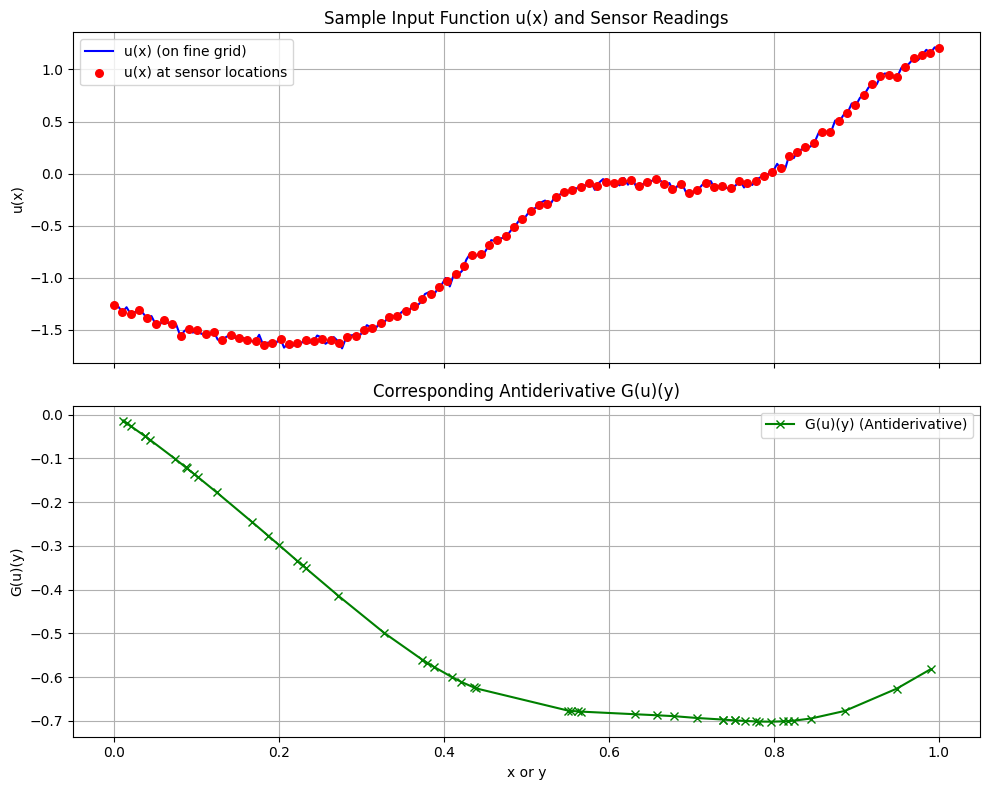

In [11]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot u(x)
axs[0].plot(x_fine_grid, u_sample_vis, label="u(x) (on fine grid)", color='blue')
axs[0].scatter(x_sensors, u_at_sensors_vis, color='red', marker='o', s=30, zorder=5, label="u(x) at sensor locations")
axs[0].set_ylabel("u(x)")
axs[0].set_title("Sample Input Function u(x) and Sensor Readings")
axs[0].legend()
axs[0].grid(True)

# Plot G(u)(y)
axs[1].plot(y_locs_vis, Gu_y_vis, label="G(u)(y) (Antiderivative)", color='green', marker='x')
axs[1].set_xlabel("x or y")
axs[1].set_ylabel("G(u)(y)")
axs[1].set_title("Corresponding Antiderivative G(u)(y)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# print(output_data)
# Check a specific data point from the generated batch


In [12]:
sample_idx_to_check = 0
print(f"\n--- Checking data point {sample_idx_to_check} from generated batch ---")
branch_val = branch_data[sample_idx_to_check]
trunk_val = trunk_data[sample_idx_to_check].item() # y_loc
output_val = output_data[sample_idx_to_check].item() # G(u)(y_loc)

print(f"y_loc (trunk input): {trunk_val:.4f}")
print(f"G(u)(y_loc) (target output): {output_val:.4f}")

# To verify this, we need to find which original u_sample this corresponds to
original_u_idx = sample_idx_to_check // num_y_per_u_train
u_original_fine_for_check = u_samples_fine_batch[original_u_idx]
print(u_original_fine_for_check)




--- Checking data point 0 from generated batch ---
y_loc (trunk input): 0.7113
G(u)(y_loc) (target output): 0.2763
[ 3.19227755e-01  4.01802033e-01  3.54267508e-01  3.39760542e-01
  3.35282147e-01  3.84417683e-01  3.09768558e-01  2.95283973e-01
  3.32802564e-01  2.97507554e-01  2.46333599e-01  2.63536453e-01
  2.66986072e-01  2.46231750e-01  1.52504668e-01  1.41704649e-01
  1.05537012e-01  1.09258704e-01  9.25064683e-02  2.92455219e-02
 -7.69102844e-05  5.02670817e-02  3.58653837e-03 -1.49196386e-03
 -2.23954525e-02 -1.12954319e-01 -1.32209614e-01 -1.31935120e-01
 -1.88011304e-01 -1.74324781e-01 -2.33089373e-01 -2.60267794e-01
 -3.03309202e-01 -3.18120331e-01 -2.75824875e-01 -3.40643764e-01
 -3.63650143e-01 -3.36504608e-01 -4.50525463e-01 -3.86986494e-01
 -4.09987509e-01 -3.59538764e-01 -4.22612399e-01 -3.82647395e-01
 -4.78361785e-01 -4.33778793e-01 -4.78078842e-01 -4.40221637e-01
 -4.13068801e-01 -4.18776542e-01 -3.88498545e-01 -4.37212914e-01
 -3.58242810e-01 -3.51494074e-01 -3.581

In [13]:
# Recompute G(u)(y_loc) for this specific u and y_loc
recomputed_Gu_y = compute_antiderivative(u_original_fine_for_check, x_fine_grid, trunk_val, domain_start, domain_end)
print(f"Recomputed G(u)(y_loc) for verification: {recomputed_Gu_y:.4f}")
print(f"Difference: {abs(output_val - recomputed_Gu_y):.2e}")

# Also check the branch input
u_at_sensors_for_check = jnp.interp(x_sensors.flatten(), x_fine_grid.flatten(), u_original_fine_for_check)
print(f"Max diff in branch input: {jnp.max(jnp.abs(branch_val - u_at_sensors_for_check)):.2e}")

Recomputed G(u)(y_loc) for verification: 0.2763
Difference: 0.00e+00
Max diff in branch input: 0.00e+00


The number num_u_samples (e.g., 1000) is the number of u functions we create. For each of these u functions, we find its value at the 50 sensor positions. Then, for that same u function, we find the output value at 20 different y locations.

### Step 1:Defining the Deeponet architecture


In [14]:
def mse_loss(true_y, pred_y):
    """Calculates the Mean Squared Error loss."""
    return jnp.mean((true_y - pred_y)**2)

In [37]:
# --- Sub-network for the input function u(x) ---
class BranchNet(nn.Module):
    features: Tuple[int, ...]
    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.Dense(feat)(x)
            x = nn.relu(x)
        # No activation on the final layer
        x = nn.Dense(self.features[-1])(x)
        return x

# --- Sub-network for the query location y ---
class TrunkNet(nn.Module):
    features: Tuple[int, ...]
    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.Dense(feat)(x)
            x = nn.relu(x)
        # No activation on the final layer
        x = nn.Dense(self.features[-1])(x)
        return x

# --- The Main DeepONet Class ---
class SingleDeepONet(nn.Module):
    branch_features: Tuple[int, ...]
    trunk_features: Tuple[int, ...]

    # Define submodules in setup
    def setup(self):
        self.branch = BranchNet(self.branch_features)
        self.trunk = TrunkNet(self.trunk_features)

    def __call__(self, branch_x, trunk_x):
        # branch_x is the input function at sensor locations, shape: (batch, num_sensors)
        # trunk_x is the query location y, shape: (batch, 1)

        branch_output = self.branch(branch_x)
        trunk_output = self.trunk(trunk_x)

        # The core of DeepONet: a dot product between the two network outputs
        # We use element-wise multiplication and then sum along the feature dimension
        output = jnp.sum(branch_output * trunk_output, axis=-1)

        return output

class StackedDeepONet(nn.Module):
  branch_features: Tuple[int, ...]
  trunk_features: Tuple[int, ...]
  num_stacks: int

  # Define stacked experts in setup
  def setup(self):
    self.experts = [
        SingleDeepONet(self.branch_features, self.trunk_features, name=f"stack_{i}") for i in range(self.num_stacks)
    ]
    self.b = self.param('b', nn.initializers.zeros, (1,))


  def __call__(self, branch_x, trunk_x):
    # Apply each expert to the inputs
    outputs = [expert(branch_x, trunk_x) for expert in self.experts]
    total_output = jnp.stack(outputs, axis= -1).sum(axis=-1)

    return total_output + self.b

### Step 2: The Training and Evaluation Logic

In [38]:
@jax.jit
def train_step_deeponet(state, batch):
    """Trains the model for one step."""
    branch_input, trunk_input, targets = batch

    def loss_fn(params):
        predictions = state.apply_fn({'params': params}, branch_input, trunk_input)
        return mse_loss(targets, predictions.reshape(-1, 1)) # Ensure shapes match

    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    loss = loss_fn(state.params) # Calculate loss again for logging
    return state, loss


def eval_model_deeponet(params, model, data):
    """Evaluates the model on a dataset."""
    branch_input, trunk_input, targets = data
    predictions = model.apply({'params': params}, branch_input, trunk_input)
    return mse_loss(targets.flatten(), predictions.flatten()) # Ensure shapes match

jitted_eval_model_deeponet = jax.jit(eval_model_deeponet, static_argnums=(1,))

In [39]:
# --- Hyperparameter Configuration for Stacked DeepONet ---
hyperparams_stacked = {
    "learning_rate": 1e-3,
    "num_stacks": 5,
    "branch_depth": 3,
    "branch_width": 40,   # Note: Width can often be smaller per stack
    "trunk_depth": 3,
    "trunk_width": 40,    # Note: Width can often be smaller per stack
    "num_epochs": 10000,
    "batch_size": 256
}

In [40]:
# Initialize the Stacked DeepONet model
print("Buildind Stacked DeepOnet Model...")
branch_feats = (num_sensors,) + (hyperparams_stacked['branch_width'],)* hyperparams_stacked['branch_depth']
trunk_feats = (1,) + (hyperparams_stacked['trunk_width'],) * hyperparams_stacked['trunk_depth']

# verify the type
print(f"Type of branch_feats: {type(branch_feats)}")

stacked_model = StackedDeepONet(
    branch_features = branch_feats,
    trunk_features = trunk_feats,
    num_stacks = hyperparams_stacked['num_stacks']
)

key_init, _ = jax.random.split(jax.random.PRNGKey(42))
dummy_branch_input = jnp.ones([1, num_sensors])
dummy_trunk_input = jnp.ones([1, 1])
params = stacked_model.init(key_init, dummy_branch_input, dummy_trunk_input)['params']

Buildind Stacked DeepOnet Model...
Type of branch_feats: <class 'tuple'>


In [41]:
# Initialize Optimizer and TrainState
optimizer = optax.adam(learning_rate=hyperparams_stacked['learning_rate'])
state_stacked_do = train_state.TrainState.create(apply_fn=stacked_model.apply, params=params, tx=optimizer)

In [42]:
# --- 3. The Training Loop (using the same train/eval functions) ---
print(f"Starting Stacked DeepONet training with {hyperparams_stacked['num_stacks']} stacks...")
train_losses_stacked_do = []
test_losses_stacked_do = []

num_train_samples = branch_data.shape[0]
steps_per_epoch = num_train_samples // hyperparams_stacked['batch_size']

for epoch in range(hyperparams_stacked['num_epochs']):
    # --- Training Phase ---
    key_shuffle, _ = jax.random.split(jax.random.PRNGKey(epoch))
    perm = jax.random.permutation(key_shuffle, num_train_samples)
    shuffled_branch, shuffled_trunk, shuffled_output = branch_data[perm], trunk_data[perm], output_data[perm]

    epoch_train_loss = 0
    for i in range(steps_per_epoch):
        start_idx, end_idx = i * hyperparams_stacked['batch_size'], (i + 1) * hyperparams_stacked['batch_size']
        batch = (shuffled_branch[start_idx:end_idx], shuffled_trunk[start_idx:end_idx], shuffled_output[start_idx:end_idx])
        # We can reuse the same train_step_deeponet function!
        state_stacked_do, loss = train_step_deeponet(state_stacked_do, batch)
        epoch_train_loss += loss

    avg_epoch_loss = epoch_train_loss / steps_per_epoch
    train_losses_stacked_do.append(avg_epoch_loss)

    # --- Evaluation Phase ---
    # We can reuse the same eval_model_deeponet function!
    current_test_loss = jitted_eval_model_deeponet(state_stacked_do.params, stacked_model, (branch_test, trunk_test, output_test))
    test_losses_stacked_do.append(current_test_loss)

    if (epoch + 1) % 1000 == 0:
        print(f"  Epoch {epoch+1}, Train Loss: {avg_epoch_loss:.6f}, Test Loss: {current_test_loss:.6f}")

print("Stacked DeepONet training finished!")

Starting Stacked DeepONet training with 5 stacks...
  Epoch 1000, Train Loss: 0.000012, Test Loss: 0.000032
  Epoch 2000, Train Loss: 0.000015, Test Loss: 0.000040
  Epoch 3000, Train Loss: 0.000004, Test Loss: 0.000012
  Epoch 4000, Train Loss: 0.000004, Test Loss: 0.000009
  Epoch 5000, Train Loss: 0.000002, Test Loss: 0.000008
  Epoch 6000, Train Loss: 0.000010, Test Loss: 0.000024
  Epoch 7000, Train Loss: 0.000001, Test Loss: 0.000007
  Epoch 8000, Train Loss: 0.000002, Test Loss: 0.000009
  Epoch 9000, Train Loss: 0.000004, Test Loss: 0.000012
  Epoch 10000, Train Loss: 0.000002, Test Loss: 0.000008
Stacked DeepONet training finished!


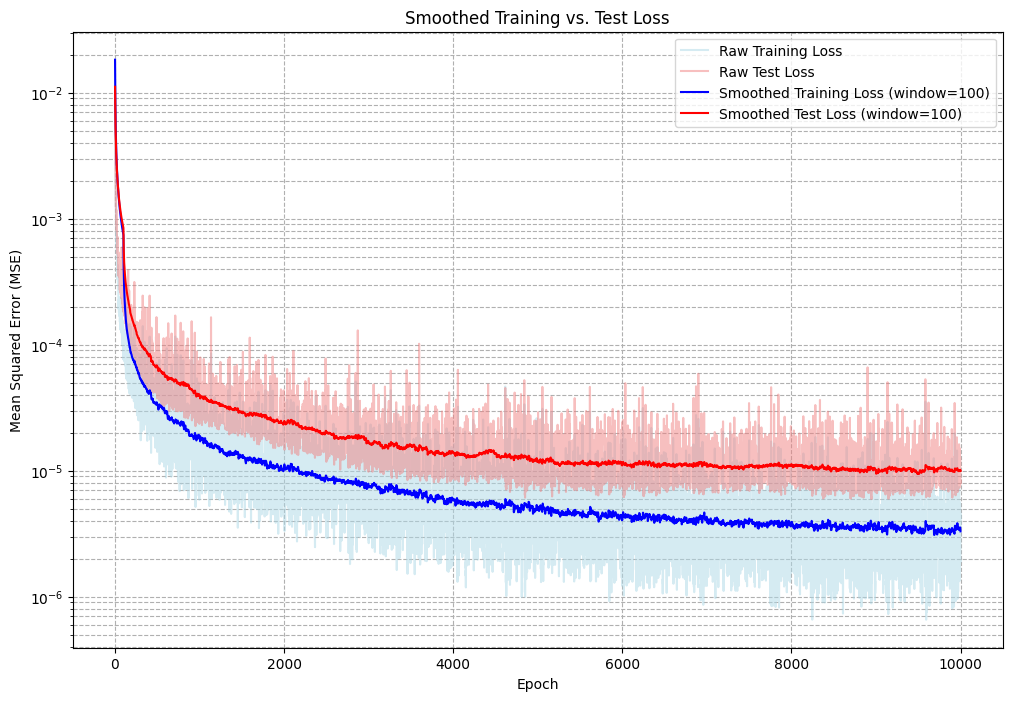

In [47]:
import pandas as pd


#  pandas Series for easy calculation
train_series = pd.Series(train_losses_stacked_do)
test_series = pd.Series(test_losses_stacked_do)

#  the smoothing window size
# A window of 100 means each point will be the average of the previous 100 points.
smoothing_window = 100

# Calculate the moving average
train_smooth = train_series.rolling(window=smoothing_window, min_periods=1).mean()
test_smooth = test_series.rolling(window=smoothing_window, min_periods=1).mean()

# Plotting
plt.figure(figsize=(12, 8))
epochs_range = range(1, hyperparams_stacked['num_epochs'] + 1)

# Plot the original, noisy data (optional, in a lighter color)
plt.plot(epochs_range, train_series, color='lightblue', alpha=0.5, label='Raw Training Loss')
plt.plot(epochs_range, test_series, color='lightcoral', alpha=0.5, label='Raw Test Loss')

# Plot the new, smoothed data (in a darker, solid color)
plt.plot(epochs_range, train_smooth, color='blue', label=f'Smoothed Training Loss (window={smoothing_window})')
plt.plot(epochs_range, test_smooth, color='red', label=f'Smoothed Test Loss (window={smoothing_window})')

plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Smoothed Training vs. Test Loss")
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()